### Build a DNN for ECG Signal Classification (5 classes)  - Pytorch
This is the implementation of an MLP for classifying the ECG signals. <br>
Your task is to design new DNNs for ECG signal classification <br>
You can use this file as a template

In [252]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim

## The Neural Network: MLP  (Replace this with your network and rename the file)

In [253]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=187, out_features=200)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2, padding=0)

        self.linear2 = nn.Linear(100, 100)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2, padding=0)

        self.linear3 = nn.Linear(50, 50)
        self.norm1 = nn.BatchNorm1d(100)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2, padding=0)

        self.linear4 = nn.Linear(50, 50)
        self.norm2 = nn.BatchNorm1d(50)

        self.linear5 = nn.Linear(50, 50)
        self.norm3 = nn.BatchNorm1d(50)

        self.linear6 = nn.Linear(50, 5)
        
    def forward(self, x):
        x1 = nnF.relu(self.linear1(x))
        x_pool1 = self.pool1(x1)

        x2 = nnF.relu(self.linear2(x_pool1))
        x2= self.norm1(x2)
        x2 += x_pool1 # Add the pooling of first layer to the second layer 
        x_pool2 = self.pool2(x2.view(x.size(0), 1, -1))

        x3 = self.norm2(F.relu(self.linear3(x_pool2.view(x.size(0), -1))))
        x3 += x_pool2.view(x.size(0), -1) # Add the pooling of second layer to the third layer

        x4 = self.norm3(F.relu(self.linear4(x3)))
        x4 += x3 # Add the output of third layer to the fourth layer

        x = self.linear5(x4)
        z = torch.sigmoid(x)
        return z

In [254]:
#debug your network here
#make sure it works for one single input sample
model=Net()
x=torch.rand(2,187) # x=torch.rand(2,187) with batch_size =2 if using BatchNorm
#x=torch.rand(10,1,187) if network is CNN
z=model(x)

In [255]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [256]:
def cal_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the standard classification accuracy
    M=confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()    
    sens=np.zeros(M.shape[0])
    prec=np.zeros(M.shape[0]) 
    for n in range(0, M.shape[0]):
        TP=M[n,n]
        FN=np.sum(M[n,:])-TP
        FP=np.sum(M[:,n])-TP
        sens[n]=TP/(TP+FN)
        prec[n]=TP/(TP+FP)       
    return acc, sens, prec

## The function to train the model

In [257]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    loss_train=0
    acc_train =0 
    sample_count=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear grad of each parameter
        Z = model(X)#forward pass
        loss = nnF.cross_entropy(Z, Y)
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()
        #do not need softmax
        Yp = Z.data.max(dim=1)[1]  # get the index of the max               
        acc_train+= torch.sum(Yp==Y).item()
        sample_count+=X.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    #due to upsampling, len(dataloader.dataset) != sample_count
    #acc_train/=len(dataloader.dataset) 
    acc_train/=sample_count    
    return loss_train, acc_train

## The Function to test the model

In [258]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    acc_test =0
    confusion=np.zeros((5,5))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass
            #do not need softmax
            Yp = Z.data.max(dim=1)[1]  # get the index of the max 
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 5):
                for j in range(0, 5):
                    confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    acc, sens, prec=cal_accuracy(confusion)
    return acc, (confusion, sens, prec)

## Load data and create dataloaders

In [259]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        #we can use DatasetName[idx] to get a data point (x,y) with index idx
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.int64)
        #x=x.reshape(1,-1) if network is CNN
        return x, y

In [260]:
import pandas as pd
X=pd.read_csv('ECG_dataX.csv')
Y=pd.read_csv('ECG_dataY.csv')

In [261]:
#convert dataframe to numpy array
X=X.values
X.shape

(3841, 187)

In [262]:
#convert dataframe to numpy array
Y=Y.values
Y.shape

(3841, 1)

In [263]:
#reshape Y into a 1D array
Y=Y.reshape(-1)
Y.shape

(3841,)

(array([800.,   0., 800.,   0.,   0., 800.,   0., 641.,   0., 800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

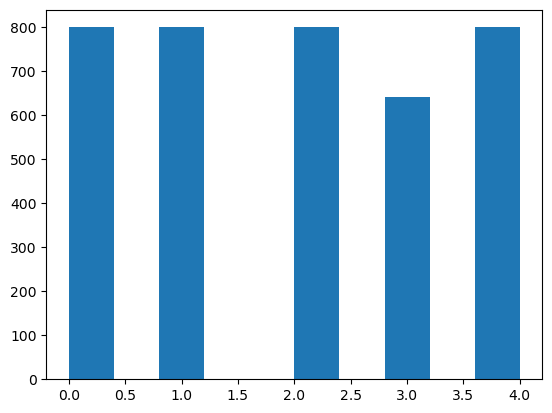

In [264]:
plt.hist(Y)

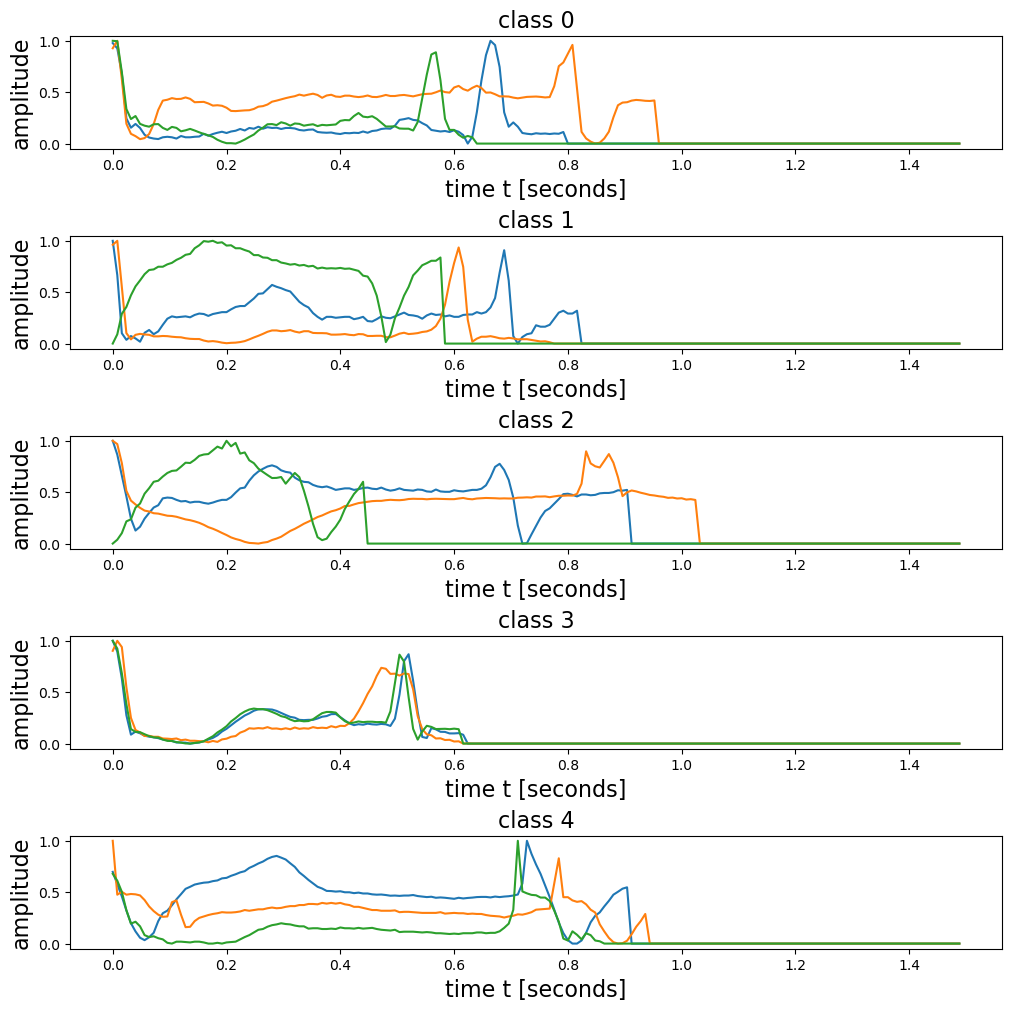

In [265]:
fs=125  # sampling frequency
Ts=1/fs # sampling interval
N=187 # the number of timepoints
Duration=N*Ts # duration of a signal
t=np.linspace(0, Duration-Ts, N) # array of timepoints
fig, ax = plt.subplots(5,1,constrained_layout=True, figsize=(10,10))
for c in range(0, 5):   
    for n in range(0, 3):
        idx=np.random.randint(0,10)
        ax[c].plot(t, X[Y==c][idx])        
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title('class '+str(c), fontsize=16)

In [266]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

In [267]:
dataset_train=MyDataset(X_train, Y_train)
dataset_val=MyDataset(X_val, Y_val)
dataset_test=MyDataset(X_test, Y_test)

In [268]:
loader_train = torch_dataloader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
loader_val = torch_dataloader(dataset_val, batch_size=128, shuffle=False, num_workers=0) 
loader_test = torch_dataloader(dataset_test, batch_size=128, shuffle=False, num_workers=0) 

## Create a model, and start the traning-validation-testing process

In [269]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net()
model.to(device)
#the code below may cause error if BatchNorm is used, you may delete those without affecting the rest of the file
#x=dataset_train[0][0]
#x=x.view(1,187).to(device) #change it to x=x.view(1,1,187).to(device) for CNN
#z=model(x)

Net(
  (linear1): Linear(in_features=187, out_features=200, bias=True)
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (pool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (linear3): Linear(in_features=50, out_features=50, bias=True)
  (norm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (linear4): Linear(in_features=50, out_features=50, bias=True)
  (norm2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear5): Linear(in_features=50, out_features=50, bias=True)
  (norm3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear6): Linear(in_features=50, out_features=5, bias=True)
)

In [270]:
y_hat=nnF.softmax(z, dim=1)
y_hat

tensor([[0.0198, 0.0180, 0.0258, 0.0212, 0.0256, 0.0238, 0.0280, 0.0246, 0.0283,
         0.0230, 0.0185, 0.0190, 0.0191, 0.0187, 0.0140, 0.0219, 0.0184, 0.0193,
         0.0231, 0.0184, 0.0165, 0.0219, 0.0169, 0.0201, 0.0209, 0.0173, 0.0215,
         0.0238, 0.0224, 0.0168, 0.0191, 0.0162, 0.0237, 0.0194, 0.0180, 0.0216,
         0.0202, 0.0147, 0.0193, 0.0167, 0.0213, 0.0177, 0.0246, 0.0161, 0.0187,
         0.0179, 0.0144, 0.0141, 0.0227, 0.0172],
        [0.0189, 0.0204, 0.0144, 0.0174, 0.0156, 0.0164, 0.0143, 0.0157, 0.0138,
         0.0170, 0.0199, 0.0218, 0.0216, 0.0212, 0.0284, 0.0167, 0.0207, 0.0196,
         0.0168, 0.0223, 0.0226, 0.0172, 0.0216, 0.0195, 0.0185, 0.0222, 0.0179,
         0.0164, 0.0180, 0.0243, 0.0202, 0.0233, 0.0161, 0.0210, 0.0214, 0.0194,
         0.0195, 0.0257, 0.0193, 0.0237, 0.0200, 0.0209, 0.0150, 0.0237, 0.0211,
         0.0215, 0.0275, 0.0276, 0.0179, 0.0246]], grad_fn=<SoftmaxBackward0>)

use stochastic gradient descent as the optimization method

In [271]:
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-4)

In [272]:
loss_train_list=[]
acc_train_list=[]
acc_val_list=[]
epoch_save=-1

train/val/test over many epochs

In [273]:
for epoch in range(epoch_save+1, 100): #change 100 to a larger number if necessary
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    acc_val, other_val = test(model, device, loader_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation acc:', acc_val)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              acc_val_list, other_val)
    save_checkpoint('ECG_MLP_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch

Train Epoch: 0 [0%]	Loss: 3.963278
epoch 0 training loss: 3.664773540063338 acc: 0.4243849493487699
epoch 0 validation acc: 0.30194804
saved: ECG_MLP_Pytorch_epoch0.pt


/var/folders/jl/kzj9mlrx3fz83wmz4qsd35gm0000gn/T/ipykernel_37346/3076453557.py:13: RuntimeWarning: invalid value encountered in scalar divide
  prec[n]=TP/(TP+FP)


Train Epoch: 1 [0%]	Loss: 3.575550
epoch 1 training loss: 3.5206420963460747 acc: 0.6888567293777135
epoch 1 validation acc: 0.5555556
saved: ECG_MLP_Pytorch_epoch1.pt
Train Epoch: 2 [0%]	Loss: 3.486449
epoch 2 training loss: 3.4571902535178443 acc: 0.7250361794500724
epoch 2 validation acc: 0.66445184
saved: ECG_MLP_Pytorch_epoch2.pt
Train Epoch: 3 [0%]	Loss: 3.408842
epoch 3 training loss: 3.397492755543102 acc: 0.7492764109985528
epoch 3 validation acc: 0.7029703
saved: ECG_MLP_Pytorch_epoch3.pt
Train Epoch: 4 [0%]	Loss: 3.356630
epoch 4 training loss: 3.3297195001081987 acc: 0.7608538350217077
epoch 4 validation acc: 0.6970684
saved: ECG_MLP_Pytorch_epoch4.pt
Train Epoch: 5 [0%]	Loss: 3.296512
epoch 5 training loss: 3.2514337301254272 acc: 0.765918958031838
epoch 5 validation acc: 0.7491857
saved: ECG_MLP_Pytorch_epoch5.pt
Train Epoch: 6 [0%]	Loss: 3.221037
epoch 6 training loss: 3.1724123521284624 acc: 0.7793053545586107
epoch 6 validation acc: 0.73376626
saved: ECG_MLP_Pytorch_ep

epoch 49 training loss: 2.9712738665667446 acc: 0.8455137481910275
epoch 49 validation acc: 0.8051948
saved: ECG_MLP_Pytorch_epoch49.pt
Train Epoch: 50 [0%]	Loss: 2.966780
epoch 50 training loss: 2.971014315431768 acc: 0.849493487698987
epoch 50 validation acc: 0.78246754
saved: ECG_MLP_Pytorch_epoch50.pt
Train Epoch: 51 [0%]	Loss: 2.976511
epoch 51 training loss: 2.9717007767070425 acc: 0.8505788712011577
epoch 51 validation acc: 0.8181818
saved: ECG_MLP_Pytorch_epoch51.pt
Train Epoch: 52 [0%]	Loss: 2.966049
epoch 52 training loss: 2.9699863412163476 acc: 0.8509406657018813
epoch 52 validation acc: 0.77597404
saved: ECG_MLP_Pytorch_epoch52.pt
Train Epoch: 53 [0%]	Loss: 2.970859
epoch 53 training loss: 2.9693221178921787 acc: 0.8469609261939218
epoch 53 validation acc: 0.8051948
saved: ECG_MLP_Pytorch_epoch53.pt
Train Epoch: 54 [0%]	Loss: 2.972827
epoch 54 training loss: 2.9689067060297187 acc: 0.8509406657018813
epoch 54 validation acc: 0.8019481
saved: ECG_MLP_Pytorch_epoch54.pt
Trai

epoch 97 training loss: 2.9601792855696245 acc: 0.900506512301013
epoch 97 validation acc: 0.8116883
saved: ECG_MLP_Pytorch_epoch97.pt
Train Epoch: 98 [0%]	Loss: 2.962605
epoch 98 training loss: 2.9605282978578047 acc: 0.8958031837916064
epoch 98 validation acc: 0.83441556
saved: ECG_MLP_Pytorch_epoch98.pt
Train Epoch: 99 [0%]	Loss: 2.960381
epoch 99 training loss: 2.9602697870948096 acc: 0.8986975397973951
epoch 99 validation acc: 0.84415585
saved: ECG_MLP_Pytorch_epoch99.pt


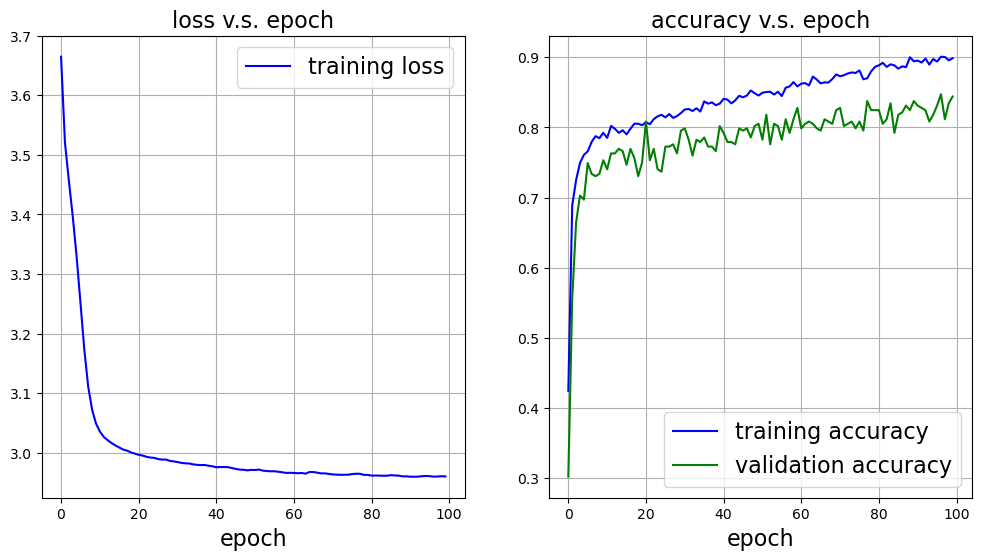

In [274]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('loss v.s. epoch',fontsize=16)
ax[0].plot(loss_train_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize=16)
ax[1].plot(acc_train_list, '-b', label='training accuracy')
ax[1].plot(acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

load the best model

In [275]:
best_epoch=np.argmax(acc_val_list)
best_epoch

96

In [276]:
checkpoint=torch.load('ECG_MLP_Pytorch_epoch'+str(best_epoch)+'.pt')
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device);
model.eval();

In [277]:
acc, (confusion, sens, prec) = test(model, device, loader_test)
print('Accuracy (average)', acc)
print('Sensitivity', sens)
print('Precision', prec)
print('Confusion \n', confusion)

Accuracy (average) 0.8543563
Sensitivity [0.73863637 0.8116883  0.89726025 0.94262296 0.91228068]
Precision [0.77380955 0.79617834 0.8618421  0.85820895 0.98734176]
Confusion 
 [[130.  29.   9.   7.   1.]
 [ 24. 125.   2.   3.   0.]
 [  5.   0. 131.   9.   1.]
 [  3.   0.   4. 115.   0.]
 [  6.   3.   6.   0. 156.]]
